In [ ]:
cd drive/MyDrive/Colab\ Notebooks/CS3033\ Final\ Project/results_xf

/content/drive/.shortcut-targets-by-id/1ys85tT914ph5XYcchx1AzNxqHH3eO0Qe/CS3033 Final Project/results_xf


In [ ]:
ls

data/                          resnest50_bottleneck.pt
resnest50_bottleneck.csv       resnest50_bottleneck_v100.csv
resnest50_bottleneck_p100.csv  resnest50_bottleneck_v100.pt
resnest50_bottleneck_p100.pt   transfer_bottleneck.csv


In [ ]:
import math
import torch
import torch.nn as nn

# from .splat import SplAtConv2d, DropBlock2D
# from .build import RESNEST_MODELS_REGISTRY

## Split attention convolution

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Conv2d, Module, Linear, BatchNorm2d, ReLU
from torch.nn.modules.utils import _pair

__all__ = ['SplAtConv2d', 'DropBlock2D']

class DropBlock2D(object):
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

class SplAtConv2d(Module):
    """Split-Attention Conv2d
    """
    def __init__(self, in_channels, channels, kernel_size, stride=(1, 1), padding=(0, 0),
                 dilation=(1, 1), groups=1, bias=True,
                 radix=2, reduction_factor=4,
                 rectify=False, rectify_avg=False, norm_layer=None,
                 dropblock_prob=0.0, **kwargs):
        super(SplAtConv2d, self).__init__()
        padding = _pair(padding)
        self.rectify = rectify and (padding[0] > 0 or padding[1] > 0)
        self.rectify_avg = rectify_avg
        inter_channels = max(in_channels*radix//reduction_factor, 32)
        self.radix = radix
        self.cardinality = groups
        self.channels = channels
        self.dropblock_prob = dropblock_prob
        # if self.rectify:
        #     from rfconv import RFConv2d
        #     self.conv = RFConv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
        #                          groups=groups*radix, bias=bias, average_mode=rectify_avg, **kwargs)
        # else:
        
        self.conv = Conv2d(in_channels, channels*radix, kernel_size, stride, padding, dilation,
                               groups=groups*radix, bias=bias, **kwargs)
        self.use_bn = norm_layer is not None
        if self.use_bn:
            self.bn0 = norm_layer(channels*radix)
        self.relu = ReLU(inplace=True)
        self.fc1 = Conv2d(channels, inter_channels, 1, groups=self.cardinality)
        if self.use_bn:
            self.bn1 = norm_layer(inter_channels)
        self.fc2 = Conv2d(inter_channels, channels*radix, 1, groups=self.cardinality)
        # if dropblock_prob > 0.0:
        #     self.dropblock = DropBlock2D(dropblock_prob, 3)
        self.rsoftmax = rSoftMax(radix, groups)

    def forward(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.bn0(x)
        if self.dropblock_prob > 0.0:
            x = self.dropblock(x)
        x = self.relu(x)

        batch, rchannel = x.shape[:2]
        if self.radix > 1:
            if torch.__version__ < '1.5':
                splited = torch.split(x, int(rchannel//self.radix), dim=1)
            else:
                splited = torch.split(x, rchannel//self.radix, dim=1)
            gap = sum(splited) 
        else:
            gap = x
        gap = F.adaptive_avg_pool2d(gap, 1)
        gap = self.fc1(gap)

        if self.use_bn:
            gap = self.bn1(gap)
        gap = self.relu(gap)

        atten = self.fc2(gap)
        atten = self.rsoftmax(atten).view(batch, -1, 1, 1)

        if self.radix > 1:
            if torch.__version__ < '1.5':
                attens = torch.split(atten, int(rchannel//self.radix), dim=1)
            else:
                attens = torch.split(atten, rchannel//self.radix, dim=1)
            out = sum([att*split for (att, split) in zip(attens, splited)])
        else:
            out = atten * x
        return out.contiguous()

class rSoftMax(nn.Module):
    def __init__(self, radix, cardinality):
        super().__init__()
        self.radix = radix
        self.cardinality = cardinality

    def forward(self, x):
        batch = x.size(0)
        if self.radix > 1:
            x = x.view(batch, self.cardinality, self.radix, -1).transpose(1, 2)
            x = F.softmax(x, dim=1)
            x = x.reshape(batch, -1)
        else:
            x = torch.sigmoid(x)
        return x

## BasicBlock

In [ ]:
class BasicBlock(nn.Module):
    """ResNet BasicBlock
    """
    # pylint: disable=unused-argument
    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(BasicBlock, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=3, padding=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        # self.conv3 = nn.Conv2d(
        #     group_width, planes * 4, kernel_size=1, bias=False)
        # self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        # out = self.conv3(out)
        # out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## Bottleneck

In [ ]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self):
        """Global average pooling over the input's spatial dimensions"""
        super(GlobalAvgPool2d, self).__init__()

    def forward(self, inputs):
        return nn.functional.adaptive_avg_pool2d(inputs, 1).view(inputs.size(0), -1)

class Bottleneck(nn.Module):
    """ResNet Bottleneck
    """
    # pylint: disable=unused-argument
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None,
                 radix=1, cardinality=1, bottleneck_width=64,
                 avd=False, avd_first=False, dilation=1, is_first=False,
                 rectified_conv=False, rectify_avg=False,
                 norm_layer=None, dropblock_prob=0.0, last_gamma=False):
        super(Bottleneck, self).__init__()
        group_width = int(planes * (bottleneck_width / 64.)) * cardinality
        self.conv1 = nn.Conv2d(inplanes, group_width, kernel_size=1, bias=False)
        self.bn1 = norm_layer(group_width)
        self.dropblock_prob = dropblock_prob
        self.radix = radix
        self.avd = avd and (stride > 1 or is_first)
        self.avd_first = avd_first

        if self.avd:
            self.avd_layer = nn.AvgPool2d(3, stride, padding=1)
            stride = 1

        if dropblock_prob > 0.0:
            self.dropblock1 = DropBlock2D(dropblock_prob, 3)
            if radix == 1:
                self.dropblock2 = DropBlock2D(dropblock_prob, 3)
            self.dropblock3 = DropBlock2D(dropblock_prob, 3)

        if radix >= 1:
            self.conv2 = SplAtConv2d(
                group_width, group_width, kernel_size=3,
                stride=stride, padding=dilation,
                dilation=dilation, groups=cardinality, bias=False,
                radix=radix, rectify=rectified_conv,
                rectify_avg=rectify_avg,
                norm_layer=norm_layer,
                dropblock_prob=dropblock_prob)
        elif rectified_conv:
            from rfconv import RFConv2d
            self.conv2 = RFConv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False,
                average_mode=rectify_avg)
            self.bn2 = norm_layer(group_width)
        else:
            self.conv2 = nn.Conv2d(
                group_width, group_width, kernel_size=3, stride=stride,
                padding=dilation, dilation=dilation,
                groups=cardinality, bias=False)
            self.bn2 = norm_layer(group_width)

        self.conv3 = nn.Conv2d(
            group_width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = norm_layer(planes*4)

        if last_gamma:
            from torch.nn.init import zeros_
            zeros_(self.bn3.weight)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.dilation = dilation
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock1(out)
        out = self.relu(out)

        if self.avd and self.avd_first:
            out = self.avd_layer(out)

        out = self.conv2(out)
        if self.radix == 0:
            out = self.bn2(out)
            if self.dropblock_prob > 0.0:
                out = self.dropblock2(out)
            out = self.relu(out)

        if self.avd and not self.avd_first:
            out = self.avd_layer(out)

        out = self.conv3(out)
        out = self.bn3(out)
        if self.dropblock_prob > 0.0:
            out = self.dropblock3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet

In [ ]:
class ResNet(nn.Module):
    """ResNet Variants
    Parameters
    ----------
    block : Block
        Class for the residual block. Options are BasicBlockV1, BottleneckV1.
    layers : list of int
        Numbers of layers in each block
    classes : int, default 1000
        Number of classification classes.
    dilated : bool, default False
        Applying dilation strategy to pretrained ResNet yielding a stride-8 model,
        typically used in Semantic Segmentation.
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    Reference:
        - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
        - Yu, Fisher, and Vladlen Koltun. "Multi-scale context aggregation by dilated convolutions."
    """
    # pylint: disable=unused-variable
    def __init__(self, block, layers, radix=1, groups=1, bottleneck_width=64,
                 num_classes=1000, dilated=False, dilation=1,
                 deep_stem=False, stem_width=64, avg_down=False,
                 rectified_conv=False, rectify_avg=False,
                 avd=False, avd_first=False,
                 final_drop=0.0, dropblock_prob=0,
                 last_gamma=False, norm_layer=nn.BatchNorm2d):
        self.cardinality = groups
        self.bottleneck_width = bottleneck_width
        # ResNet-D params
        self.inplanes = stem_width*2 if deep_stem else 64
        self.avg_down = avg_down
        self.last_gamma = last_gamma
        # ResNeSt params
        self.radix = radix
        self.avd = avd
        self.avd_first = avd_first

        super(ResNet, self).__init__()
        self.rectified_conv = rectified_conv
        self.rectify_avg = rectify_avg
        if rectified_conv:
            from rfconv import RFConv2d
            conv_layer = RFConv2d
        else:
            conv_layer = nn.Conv2d
        conv_kwargs = {'average_mode': rectify_avg} if rectified_conv else {}
        if deep_stem:
            self.conv1 = nn.Sequential(
                conv_layer(3, stem_width, kernel_size=3, stride=2, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
                norm_layer(stem_width),
                nn.ReLU(inplace=True),
                conv_layer(stem_width, stem_width*2, kernel_size=3, stride=1, padding=1, bias=False, **conv_kwargs),
            )
        else:
            self.conv1 = conv_layer(3, 64, kernel_size=7, stride=2, padding=3,
                                   bias=False, **conv_kwargs)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0], norm_layer=norm_layer, is_first=False)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, norm_layer=norm_layer)
        if dilated or dilation == 4:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=4, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        elif dilation==2:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           dilation=1, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=1,
                                           dilation=2, norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        else:
            self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
            self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                           norm_layer=norm_layer,
                                           dropblock_prob=dropblock_prob)
        self.avgpool = GlobalAvgPool2d()
        self.drop = nn.Dropout(final_drop) if final_drop > 0.0 else None
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, norm_layer):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1, dilation=1, norm_layer=None,
                    dropblock_prob=0.0, is_first=True):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            down_layers = []
            if self.avg_down:
                if dilation == 1:
                    down_layers.append(nn.AvgPool2d(kernel_size=stride, stride=stride,
                                                    ceil_mode=True, count_include_pad=False))
                else:
                    down_layers.append(nn.AvgPool2d(kernel_size=1, stride=1,
                                                    ceil_mode=True, count_include_pad=False))
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=1, bias=False))
            else:
                down_layers.append(nn.Conv2d(self.inplanes, planes * block.expansion,
                                             kernel_size=1, stride=stride, bias=False))
            down_layers.append(norm_layer(planes * block.expansion))
            downsample = nn.Sequential(*down_layers)

        layers = []
        if dilation == 1 or dilation == 2:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=1, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        elif dilation == 4:
            layers.append(block(self.inplanes, planes, stride, downsample=downsample,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=2, is_first=is_first, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))
        else:
            raise RuntimeError("=> unknown dilation size: {}".format(dilation))

        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                radix=self.radix, cardinality=self.cardinality,
                                bottleneck_width=self.bottleneck_width,
                                avd=self.avd, avd_first=self.avd_first,
                                dilation=dilation, rectified_conv=self.rectified_conv,
                                rectify_avg=self.rectify_avg,
                                norm_layer=norm_layer, dropblock_prob=dropblock_prob,
                                last_gamma=self.last_gamma))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        if self.drop:
            x = self.drop(x)
        x = self.fc(x)

        return x

In [ ]:
def resnet50(pretrained=False, root='~/.encoding/models', **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(torch.hub.load_state_dict_from_url(
            resnest_model_urls['resnet50'], progress=True, check_hash=True))
    return model

## Train

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms
from torchvision import datasets
from torchvision.datasets import CIFAR100
from torch.utils.data.sampler import SubsetRandomSampler

import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# cd drive/MyDrive/Colab\ Notebooks/3033_HW4

dataloader

In [ ]:
data_dir = 'data/cifar10'
batch_size = 128

def get_data_loaders(data_dir,
                     batch_size,
                     train_transform,
                     test_transform,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=False):
    """
    Adapted from: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
    
    Utility function for loading and returning train and test
    multi-process iterators over the CIFAR-10 dataset.
    If using CUDA, set pin_memory to True.
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - train_transform: pytorch transforms for the training set
    - test_transform: pytorch transofrms for the test set
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    
    Returns
    -------
    - train_loader: training set iterator.
    - test_loader:  test set iterator.
    """
    
    # Load the datasets
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    test_dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=test_transform,
    )
    
    # Create loader objects
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )
          
    return (train_loader, test_loader)

train & evaluate

In [ ]:
def evaluate(model, data_loader, device):
    """
    Calculate classification error (%) for given model
    and data set.
    
    Parameters:
    
    - model: A Trained Pytorch Model 
    - data_loader: A Pytorch data loader object
    """
    
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))
    
    error = np.sum(y_pred != y_true) / len(y_true)
    return error



def train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, RESULTS_PATH, scheduler=None, MODEL_PATH=None):
    """
    End to end training as described by the original resnet paper:
    https://arxiv.org/abs/1512.03385
    
    Parameters
    ----------------
    
    - model: The PyTorch model to be trained
    - n:   Determines depth of the neural network 
           as described in paper
    - train_loader: 
           PyTorch dataloader object for training set
    - test_loader: 
           PyTorch dataloader object for test set
    """
    
    # Run on GPU if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    
    # Training loop
    # -------------------------------
    cols       = ['epoch', 'train_loss', 'train_acc', 'test_acc', 'time']
    results_df = pd.DataFrame(columns=cols).set_index('epoch')
    # print('Epoch \tBatch \tNLLLoss_Train')
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        start = time.time()
        model.train()
        running_loss  = 0.0
        best_test_err = 1.0
        for i, data in enumerate(train_loader, 0):   # Do a batch iteration
            
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # # print average loss for last 50 mini-batches
            # running_loss += loss.item()
            # if i % 50 == 49:
            #     print('%d \t%d \t%.3f' %
            #           (epoch + 1, i + 1, running_loss / 50))
            #     running_loss = 0.0
        
        end = time.time()

        if scheduler:
            scheduler.step()
        
        # Record metrics
        model.eval()
        train_loss = np.round(loss.item(), 4)
        train_err = evaluate(model, train_loader, device)
        test_err = evaluate(model, test_loader, device)
        train_acc = np.round(1 - train_err, 4)
        test_acc = np.round(1 - test_err, 4)
        results_df.loc[epoch] = [train_loss, train_acc, test_acc, end - start]
        results_df.to_csv(RESULTS_PATH)
        print(f'epoch: {epoch} training loss: {train_loss} train_acc: {train_acc} test_acc: {test_acc} time: {end-start}')
        
        # Save best model
        if MODEL_PATH and (test_err < best_test_err):
            torch.save(model.state_dict(), MODEL_PATH)
            best_test_err = test_err
        
    print('Finished Training')
    model.eval()
    return model

data transform

In [ ]:
# Normalisation parameters fo CIFAR10
means = [0.4918687901200927, 0.49185976472299225, 0.4918583862227116]
stds  = [0.24697121702736, 0.24696766978537033, 0.2469719877121087]

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

In [ ]:
train_loader, test_loader = get_data_loaders(data_dir,
                                              batch_size,
                                              train_transform,
                                              test_transform,
                                              shuffle=True,
                                              num_workers=4,
                                              pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
epochs = 250
lr = 0.1
momentum = 0.9
weight_decay = 0.0001 
milestones = [80,210]
gamma = 0.1

### Basic Block

In [ ]:
model_basic = ResNet(BasicBlock, [3, 4, 14, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=10,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_basic.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file = f'resnest50_basic.csv'
model_file = f'resnest50_basic.pt'
train(model_basic, epochs, train_loader, test_loader, criterion, 
      optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file )

cuda:0
epoch: 0 |train_loss: 2.3386178016662598 | train_acc: 0.10402 | test_acc: 0.1066
epoch: 1 |train_loss: 2.0878043174743652 | train_acc: 0.20702 | test_acc: 0.215
epoch: 2 |train_loss: 1.7789520025253296 | train_acc: 0.27354 | test_acc: 0.286
epoch: 3 |train_loss: 1.779820203781128 | train_acc: 0.3192 | test_acc: 0.3198
epoch: 4 |train_loss: 1.7175089120864868 | train_acc: 0.3558 | test_acc: 0.3684
epoch: 5 |train_loss: 1.4531006813049316 | train_acc: 0.33676 | test_acc: 0.3578
epoch: 6 |train_loss: 1.6070306301116943 | train_acc: 0.42198 | test_acc: 0.4282
epoch: 7 |train_loss: 1.3667398691177368 | train_acc: 0.42292 | test_acc: 0.4384
epoch: 8 |train_loss: 1.5610198974609375 | train_acc: 0.31044 | test_acc: 0.3393
epoch: 9 |train_loss: 1.6339101791381836 | train_acc: 0.3239 | test_acc: 0.3474
epoch: 10 |train_loss: 1.4388227462768555 | train_acc: 0.45424 | test_acc: 0.4649
epoch: 11 |train_loss: 1.4744917154312134 | train_acc: 0.45604 | test_acc: 0.4629
epoch: 12 |train_loss: 1.

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SplAtConv2d(
      

In [ ]:
model_basic2 = ResNet(BasicBlock, [3, 4, 14, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=10,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_basic2.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file = f'results/resnest50_basic.csv'
#model_file = f'pretrained/resnet{6*n+2}.pt'
train(model_basic2, epochs, train_loader, test_loader, criterion, 
      optimizer, results_file, scheduler=scheduler)

cuda:0
epoch: 0 |train_loss: 2.335160732269287 | train_acc: 0.10184 | test_acc: 0.1007
epoch: 1 |train_loss: 2.1406619548797607 | train_acc: 0.16926 | test_acc: 0.1549
epoch: 2 |train_loss: 1.9714727401733398 | train_acc: 0.15304 | test_acc: 0.1506
epoch: 3 |train_loss: 1.7291923761367798 | train_acc: 0.27522 | test_acc: 0.2914
epoch: 4 |train_loss: 1.9194997549057007 | train_acc: 0.32032 | test_acc: 0.3487
epoch: 5 |train_loss: 1.738511323928833 | train_acc: 0.338 | test_acc: 0.3517
epoch: 6 |train_loss: 1.7082706689834595 | train_acc: 0.36368 | test_acc: 0.3768
epoch: 7 |train_loss: 1.756751298904419 | train_acc: 0.3253 | test_acc: 0.3451
epoch: 8 |train_loss: 1.4442851543426514 | train_acc: 0.37408 | test_acc: 0.3946
epoch: 9 |train_loss: 1.4072989225387573 | train_acc: 0.37126 | test_acc: 0.399
epoch: 10 |train_loss: 1.4833457469940186 | train_acc: 0.44812 | test_acc: 0.4701
epoch: 11 |train_loss: 1.5786921977996826 | train_acc: 0.42758 | test_acc: 0.4335
epoch: 12 |train_loss: 1.4

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): SplAtConv2d(
      

### Bottleneck

In [ ]:
model = ResNet(Bottleneck, [3, 4, 6, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=100,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file = 'resnest50_bottleneck_p100.csv'
model_file = 'resnest50_bottleneck_p100.pt'
train(model, epochs, train_loader, test_loader, criterion, 
      optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

In [ ]:
model2 = ResNet(Bottleneck, [3, 4, 6, 3],
                   radix=2, groups=1, bottleneck_width=64,num_classes=100,
                   deep_stem=True, stem_width=32, avg_down=True,
                   avd=True, avd_first=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)

scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
results_file = 'resnest50_bottleneck_V100.csv'
model_file = 'resnest50_bottleneck_V100.pt'
train(model2, epochs, train_loader, test_loader, criterion, 
      optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

# plot

In [ ]:
cd drive/MyDrive/Colab\ Notebooks/CS3033\ Final\ Project

/content/drive/.shortcut-targets-by-id/1ys85tT914ph5XYcchx1AzNxqHH3eO0Qe/CS3033 Final Project


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
basic = pd.read_csv("results_hg/resnest50_basic.csv")
basic

,epoch,train_loss,train_acc,test_acc
0,0,2.338618,0.10402,0.1066
1,1,2.087804,0.20702,0.2150
2,2,1.778952,0.27354,0.2860
3,3,1.779820,0.31920,0.3198
4,4,1.717509,0.35580,0.3684
...,...,...,...,...
245,245,0.001710,0.99918,0.8921
246,246,0.007363,0.99916,0.8932
247,247,0.012021,0.99924,0.8933
248,248,0.004637,0.99944,0.8939


In [ ]:
bottleneck = pd.read_csv("results_xf/resnest50_bottleneck_v100.csv")
bottleneck

,epoch,train_loss,train_acc,test_acc
0,0,2.3637,0.2014,0.2218
1,1,1.8615,0.3115,0.3356
2,2,1.7494,0.3551,0.3709
3,3,1.3441,0.3887,0.4012
4,4,1.5299,0.4240,0.4375
...,...,...,...,...
245,245,0.0125,0.9999,0.8754
246,246,0.0008,0.9999,0.8773
247,247,0.0002,0.9999,0.8756
248,248,0.0004,1.0000,0.8753


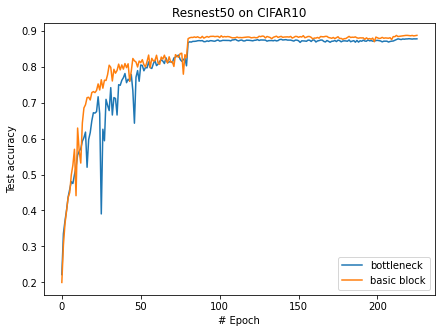

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(bottleneck['epoch'], bottleneck['test_acc'], label="bottleneck")
plt.plot(basic['epoch'], basic['test_acc'], label="basic block")
plt.xlabel("# Epoch")
plt.ylabel("Test accuracy")
plt.title("Resnest50 on CIFAR10")
plt.legend()

## transfer learning

In [ ]:
transfer_bottleneck = pd.read_csv("results_xf/transfer_bottleneck.csv")
transfer_bottleneck

,epoch,test_acc
0,0,0.1033
1,1,0.1674
2,2,0.2237
3,3,0.2673
4,4,0.3042
...,...,...
195,195,0.6163
196,196,0.6174
197,197,0.6147
198,198,0.6158


In [ ]:
transfer_basic = pd.read_csv("results_hg/transfer_basic.csv")
transfer_basic

,epoch,test_acc
0,0,0.2090
1,1,0.3008
2,2,0.3681
3,3,0.4048
4,4,0.4436
...,...,...
195,195,0.6303
196,196,0.6288
197,197,0.6312
198,198,0.6317


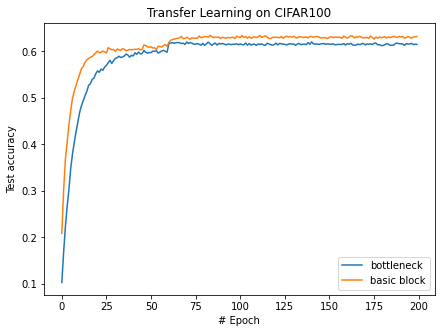

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(transfer_basic['epoch'], transfer_basic['test_acc'], label="bottleneck")

plt.plot(transfer_bottleneck['epoch'], transfer_bottleneck['test_acc'], label="basic block")

plt.xlabel("# Epoch")
plt.ylabel("Test accuracy")
plt.title("Transfer Learning on CIFAR100")
plt.legend()

In [ ]:
plt.figure(figsize=(7,5))
plt.plot(transfer_basic['epoch'], transfer_basic['test_acc'], label="basic block")
plt.plot(transfer_bottleneck['epoch'], transfer_bottleneck['test_acc'], label="bottleneck")
plt.xlabel("# Epoch")
plt.ylabel("Test accuracy")
plt.title("Transfer Learning on CIFAR100")
plt.legend()